In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from plastid import *
import seaborn as sns
import pysam
%run /project/GCRB/JChen_lab/shared/scripts/setup.py
from IPython.core.display import Image
pd.set_option('display.max_columns', None)
from collections import OrderedDict
import glob
%matplotlib inline
from itertools import combinations
import re
import multiprocessing
from Bio.Seq import Seq
from Bio import SeqIO
from Bio.Alphabet import generic_dna, generic_protein


In [2]:
plt.rcParams.update({'font.size': 13})


In [3]:
bed_path = "/project/GCRB/JChen_lab/shared/ref/human/hg19/lnc_gencode_transcriptome/lncs_gencode24.bed"
path_to_paths_file="/project/GCRB/JChen_lab/shared/data/20220311_RiboSeq_Sridevi/Sridevi/paths.txt"
genome = SeqIO.to_dict(SeqIO.parse("/project/GCRB/JChen_lab/shared/ref/human/hg19/fasta/hg19.fa", "fasta"))

In [4]:
gencode_dict = dict()
transcripts = BED_Reader(open(bed_path), return_type=Transcript)
for transcript in transcripts:
    gencode_dict[transcript.get_name()] = transcript

In [5]:
# len(gencode_dict)

In [6]:

paths = pd.read_csv(path_to_paths_file, sep='\t', index_col=0)
paths["bam_path"] = paths["count_path"].apply(lambda x: x.split('/counts/')[0] + '/alignments/' + x.split('/counts/')[1].split('_counts')[0] + '.bam')


In [7]:
paths

,assay,condition,count_path,bam_path
name,,,,
Rb_RACK1_WT_1,ribo,RACK1_WT,/project/GCRB/JChen_lab/shared/data/20220311_R...,/project/GCRB/JChen_lab/shared/data/20220311_R...
Rb_RACK1_WT_2,ribo,RACK1_WT,/project/GCRB/JChen_lab/shared/data/20220311_R...,/project/GCRB/JChen_lab/shared/data/20220311_R...
Rb_RACK1_Mut_1,ribo,RACK1_Mut,/project/GCRB/JChen_lab/shared/data/20220311_R...,/project/GCRB/JChen_lab/shared/data/20220311_R...
Rb_RACK1_Mut_2,ribo,RACK1_Mut,/project/GCRB/JChen_lab/shared/data/20220311_R...,/project/GCRB/JChen_lab/shared/data/20220311_R...
Rb_siControl_1,ribo,siControl,/project/GCRB/JChen_lab/shared/data/20220311_R...,/project/GCRB/JChen_lab/shared/data/20220311_R...
Rb_siControl_2,ribo,siControl,/project/GCRB/JChen_lab/shared/data/20220311_R...,/project/GCRB/JChen_lab/shared/data/20220311_R...
Rb_siTARG1_1,ribo,siTARG1,/project/GCRB/JChen_lab/shared/data/20220311_R...,/project/GCRB/JChen_lab/shared/data/20220311_R...
Rb_siTARG1_2,ribo,siTARG1,/project/GCRB/JChen_lab/shared/data/20220311_R...,/project/GCRB/JChen_lab/shared/data/20220311_R...
RNA_RACK1_WT_1,rna,RACK1_WT,/project/GCRB/JChen_lab/shared/data/20220311_R...,/project/GCRB/JChen_lab/shared/data/20220311_R...


In [8]:
# alignments = dict()
# alignments["WT"] = BAMGenomeArray('/work/GCRB/s195535/data/Mauro_CostaMattioli/5_eIF2A_RNaseI_cortical_RiboSeq_RNA/Ribo-Seq/alignments/WT_merge.bam')
# size_filter = SizeFilterFactory(min=31,max=34)
# alignments["WT"].add_filter("size",size_filter)
# alignments["WT"].set_mapping(FivePrimeMapFactory(offset=14))
# alignments["KO"] = BAMGenomeArray('/work/GCRB/s195535/data/Mauro_CostaMattioli/5_eIF2A_RNaseI_cortical_RiboSeq_RNA/Ribo-Seq/alignments/KO_merge.bam')
# size_filter = SizeFilterFactory(min=31,max=34)
# alignments["KO"].add_filter("size",size_filter)
# alignments["KO"].set_mapping(FivePrimeMapFactory(offset=14))

In [9]:
alignments = dict()

for i, row in paths.query('assay == "ribo"').iterrows():
    alignments[i] = BAMGenomeArray(row["bam_path"])
#     size_filter = SizeFilterFactory(min=31,max=34)
#     alignments[i].add_filter("size",size_filter)
    alignments[i].set_mapping(FivePrimeMapFactory(offset=12))


In [10]:
# %%capture --no-display
# read_pandas = dict()

def get_read_pandas(cond):
    cds_reads_list, utr5_reads_list, utr3_reads_list, names = [], [], [], []
    for orf in gencode_dict:
        cds_reads = gencode_dict[orf].get_cds().get_counts(alignments[cond])
        utr5_reads = gencode_dict[orf].get_utr5().get_counts(alignments[cond])  
        utr3_reads = gencode_dict[orf].get_utr3().get_counts(alignments[cond])
    #     cds_reads = ','.join(cds_reads)
    #     utr5_reads = ','.join(utr5_reads)
    #     utr3_reads = ','.join(utr3_reads)
        cds_reads_list.append(cds_reads)
        utr5_reads_list.append(utr5_reads)
        utr3_reads_list.append(utr3_reads)
        names.append(orf)
    read_pandas = pd.DataFrame({"name": names, "cds": cds_reads_list, "utr5": utr5_reads_list, "utr3": utr3_reads_list}).set_index('name')
    return read_pandas

In [11]:
# %%capture --no-display

# pool = multiprocessing.Pool()

# # pool object with number of element
# pool = multiprocessing.Pool(processes=len(alignments))

# # input list
# inputs = alignments.keys()

# # map the function to the list and pass
# # function and input list as arguments
# outputs = pool.map(get_read_pandas, inputs)

In [12]:
# read_pandas = dict()
# for i, cond in enumerate(inputs):
#     read_pandas[cond] = outputs[i]

In [13]:
import pickle

In [14]:
# for cond in read_pandas:
#     with open('read_count_vectors_'+cond+'.pickle', 'wb') as handle:
#         pickle.dump(read_pandas[cond], handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
read_pandas = dict()
for cond in alignments.keys():
    with open('read_count_vectors_'+cond+'.pickle', 'rb') as handle:
        read_pandas[cond] = pickle.load(handle)

In [16]:
# read_pandas["WT_1"].head()

In [17]:
# %%capture --no-display

# cds_seq_list, utr5_seq_list, utr3_seq_list, names = [], [], [], []

# for orf in gencode_dict:
#     cds_seq = Seq(gencode_dict[orf].get_cds().get_sequence(genome).upper(), generic_dna)
#     utr5_seq = Seq(gencode_dict[orf].get_utr5().get_sequence(genome).upper(), generic_dna) 
#     utr3_seq = Seq(gencode_dict[orf].get_utr3().get_sequence(genome).upper(), generic_dna)

    
#     cds_seq_list.append(str(cds_seq))
#     utr5_seq_list.append(str(utr5_seq))
#     utr3_seq_list.append(str(utr3_seq))
#     names.append(orf)
    
# seq_pandas = pd.DataFrame({"name": names, "cds": cds_seq_list, "utr5": utr5_seq_list, "utr3": utr3_seq_list}).set_index('name')

In [18]:
# seq_pandas.to_csv('gencode_sequences.txt', sep='\t')

In [19]:
seq_pandas = pd.read_csv('gencode_sequences.txt', sep='\t', index_col=0)

In [20]:
# seq_pandas.head()

In [21]:
alignments.keys()

dict_keys(['Rb_RACK1_WT_1', 'Rb_RACK1_WT_2', 'Rb_RACK1_Mut_1', 'Rb_RACK1_Mut_2', 'Rb_siControl_1', 'Rb_siControl_2', 'Rb_siTARG1_1', 'Rb_siTARG1_2'])

In [22]:
reads_start_dict = dict()

for cond in alignments.keys():

    reads_start = []
    for i, row in seq_pandas.dropna().iterrows():
        if len(row["cds"]) >= 50 and len(row["utr5"]) >= 50:
            reads_cds_start = read_pandas[cond].loc[i, "cds"][:50]
            reads_utr5 = read_pandas[cond].loc[i, "utr5"][-50:]
            reads = np.append(reads_utr5, reads_cds_start)
            if sum(reads) > 0 and len(reads) == 100:
                reads_start.append(reads/sum(reads))
    reads_start_dict[cond] = np.mean(np.array(reads_start), axis=0)



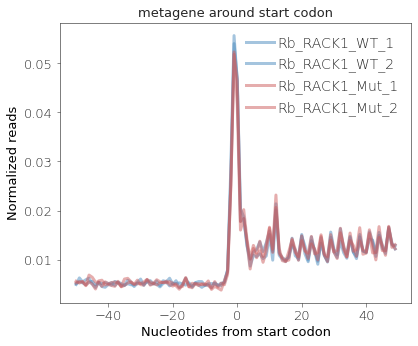

In [55]:
x_vals = range(-50, -50+len(reads_start_dict["Rb_RACK1_WT_1"]))
fig, ax = plt.subplots(1,1, figsize=(6, 5))
ax.plot(x_vals, reads_start_dict["Rb_RACK1_WT_1"], label='Rb_RACK1_WT_1', c='#4B8BBE', lw=3, alpha=0.5)
ax.plot(x_vals, reads_start_dict["Rb_RACK1_WT_2"], label='Rb_RACK1_WT_2', c='#4B8BBE', lw=3, alpha=0.5)

ax.plot(x_vals, reads_start_dict["Rb_RACK1_Mut_1"], label='Rb_RACK1_Mut_1', c='indianred', lw=3, alpha=0.5)
ax.plot(x_vals, reads_start_dict["Rb_RACK1_Mut_2"], label='Rb_RACK1_Mut_2', c='indianred', lw=3, alpha=0.5)

ax.set_xlabel('Nucleotides from start codon', fontsize=13)
ax.set_ylabel('Normalized reads', fontsize=13)
ax.legend()
ax.set_title('metagene around start codon', fontsize=13)
# x_vals = range(-30, -30+len(reads_start_mean))
# ax2.bar(x_vals, reads_stop_mean, width=1,linewidth=0, color=almost_black)
# ax2.set_ylabel('Normalized reads')
plt.tight_layout()
# Image(saveFigures(fig,'figs', 'metagene_start'))

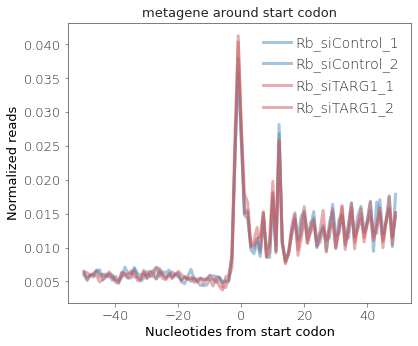

In [59]:
x_vals = range(-50, -50+len(reads_start_dict["Rb_RACK1_WT_1"]))
fig, ax = plt.subplots(1,1, figsize=(6, 5))

ax.plot(x_vals, reads_start_dict["Rb_siControl_1"], label='Rb_siControl_1', c='#4B8BBE', lw=3, alpha=0.5)
ax.plot(x_vals, reads_start_dict["Rb_siControl_2"], label='Rb_siControl_2', c='#4B8BBE', lw=3, alpha=0.5)
ax.plot(x_vals, reads_start_dict["Rb_siTARG1_1"], label='Rb_siTARG1_1', c='indianred', lw=3, alpha=0.5)
ax.plot(x_vals, reads_start_dict["Rb_siTARG1_2"], label='Rb_siTARG1_2', c='indianred', lw=3, alpha=0.5)

ax.set_xlabel('Nucleotides from start codon', fontsize=13)
ax.set_ylabel('Normalized reads', fontsize=13)
ax.legend()
ax.set_title('metagene around start codon', fontsize=13)
# x_vals = range(-30, -30+len(reads_start_mean))
# ax2.bar(x_vals, reads_stop_mean, width=1,linewidth=0, color=almost_black)
# ax2.set_ylabel('Normalized reads')
plt.tight_layout()
# Image(saveFigures(fig,'figs', 'metagene_start'))

In [27]:
reads_stop_dict = dict()

for cond in alignments.keys():

    reads_stop = []
    for i, row in seq_pandas.dropna().iterrows():
        if len(row["cds"]) >= 50 and len(row["utr3"]) >= 50:
            reads_cds_stop = read_pandas[cond].loc[i, "cds"][-50:]
            reads_utr3 = read_pandas[cond].loc[i, "utr3"][:50]
            reads = np.append(reads_cds_stop, reads_utr3)
            if sum(reads) > 0 and len(reads) == 100:
                reads_stop.append(reads/sum(reads))
    reads_stop_dict[cond] = np.mean(np.array(reads_stop), axis=0)

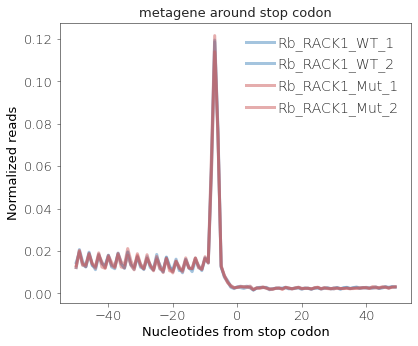

In [62]:
x_vals = range(-50, -50+len(reads_stop_dict["Rb_RACK1_WT_1"]))
fig, ax = plt.subplots(1,1, figsize=(6, 5))
ax.plot(x_vals, reads_stop_dict["Rb_RACK1_WT_1"], label='Rb_RACK1_WT_1', c='#4B8BBE', lw=3, alpha=0.5)
ax.plot(x_vals, reads_stop_dict["Rb_RACK1_WT_2"], label='Rb_RACK1_WT_2', c='#4B8BBE', lw=3, alpha=0.5)

ax.plot(x_vals, reads_stop_dict["Rb_RACK1_Mut_1"], label='Rb_RACK1_Mut_1', c='indianred', lw=3, alpha=0.5)
ax.plot(x_vals, reads_stop_dict["Rb_RACK1_Mut_2"], label='Rb_RACK1_Mut_2', c='indianred', lw=3, alpha=0.5)

ax.set_xlabel('Nucleotides from stop codon', fontsize=13)
ax.set_ylabel('Normalized reads', fontsize=13)
ax.legend()
ax.set_title('metagene around stop codon', fontsize=13)
# x_vals = range(-30, -30+len(reads_start_mean))
# ax2.bar(x_vals, reads_stop_mean, width=1,linewidth=0, color=almost_black)
# ax2.set_ylabel('Normalized reads')
plt.tight_layout()
# Image(saveFigures(fig,'figs', 'metagene_start'))

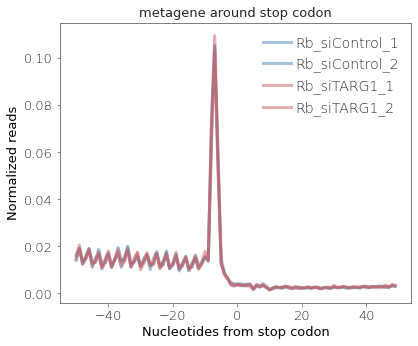

In [65]:
x_vals = range(-50, -50+len(reads_stop_dict["Rb_RACK1_WT_1"]))
fig, ax = plt.subplots(1,1, figsize=(6, 5))
ax.plot(x_vals, reads_stop_dict["Rb_siControl_1"], label='Rb_siControl_1', c='#4B8BBE', lw=3, alpha=0.5)
ax.plot(x_vals, reads_stop_dict["Rb_siControl_2"], label='Rb_siControl_2', c='#4B8BBE', lw=3, alpha=0.5)
ax.plot(x_vals, reads_stop_dict["Rb_siTARG1_1"], label='Rb_siTARG1_1', c='indianred', lw=3, alpha=0.5)

ax.plot(x_vals, reads_stop_dict["Rb_siTARG1_2"], label='Rb_siTARG1_2', c='indianred', lw=3, alpha=0.5)
ax.set_xlabel('Nucleotides from stop codon', fontsize=13)
ax.set_ylabel('Normalized reads', fontsize=13)
ax.legend()
ax.set_title('metagene around stop codon', fontsize=13)
# x_vals = range(-30, -30+len(reads_start_mean))
# ax2.bar(x_vals, reads_stop_mean, width=1,linewidth=0, color=almost_black)
# ax2.set_ylabel('Normalized reads')
plt.tight_layout()
# Image(saveFigures(fig,'figs', 'metagene_start'))

In [30]:
# with open('codon_usage_utr5.pickle', 'rb') as handle:
#     codon_usage_utr5 = pickle.load(handle)
# with open('codon_usage_cds.pickle', 'rb') as handle:
#     codon_usage_cds = pickle.load(handle)


In [31]:
def get_codon_usage_5utr(cond):
    codon_usage = dict()
    codon_usage["A"] = dict()
    codon_usage["P"] = dict()
    codon_usage["E"] = dict()
    for i, row in seq_pandas.dropna().iterrows():
        if len(row["utr5"]) >= 9:
    #         print([m.start() for m in re.finditer('CTG', row["utr5"])])
            total_reads = read_pandas[cond].loc[i, "utr5"]
            total_reads_mean = np.mean(total_reads)*3
            if float(sum(total_reads))/(len(total_reads)/3) >= 0.1:
        
                for k in range(3, len(row["utr5"]) - 5):
                    P_site = str(row["utr5"])[k:k+3]
                    A_site = str(row["utr5"])[k+3:k+6]
                    E_site = str(row["utr5"])[k-3:k]

                    usage = float(sum(read_pandas[cond].loc[i, "utr5"][k:k+3])) / total_reads_mean
                    
                    if P_site in codon_usage["P"]:
                        codon_usage["P"][P_site].append(usage)
                    else:
                        codon_usage["P"][P_site] = [usage]
                        
                    if A_site in codon_usage["A"]:
                        codon_usage["A"][A_site].append(usage)
                    else:
                        codon_usage["A"][A_site] = [usage]

                    if E_site in codon_usage["E"]:
                        codon_usage["E"][E_site].append(usage)
                    else:
                        codon_usage["E"][E_site] = [usage]

    return codon_usage


In [32]:
pool = multiprocessing.Pool()

# pool object with number of element
pool = multiprocessing.Pool(processes=8)

# input list
inputs = alignments.keys()

# map the function to the list and pass
# function and input list as arguments
outputs = pool.map(get_codon_usage_5utr, inputs)

In [33]:
codon_usage_utr5 = dict()
for i, cond in enumerate(inputs):
    codon_usage_utr5[cond] = outputs[i]

In [34]:
codon_usage_utr5_mean = dict()
for cond in alignments.keys():
    codon_usage_utr5_mean[cond] = dict()
    for codon in codon_usage_utr5[cond]["P"]:
        codon_usage_utr5_mean[cond][codon] = np.mean(codon_usage_utr5[cond]["P"][codon])



In [35]:
bases = "TCAG"
codons = [a + b + c for a in bases for b in bases for c in bases]
amino_acids = 'FFLLSSSSYY**CC*WLLLLPPPPHHQQRRRRIIIMTTTTNNKKSSRRVVVVAAAADDEEGGGG'
codon_table = dict(zip(codons, amino_acids))

In [36]:
del codon_table["TAA"]
del codon_table["TAG"]
del codon_table["TGA"]

In [37]:
for cond in alignments.keys():

    codon_usage_utr5_mean[cond] = {codon: codon_usage_utr5_mean[cond][codon] for codon in codon_table}


No handles with labels found to put in legend.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


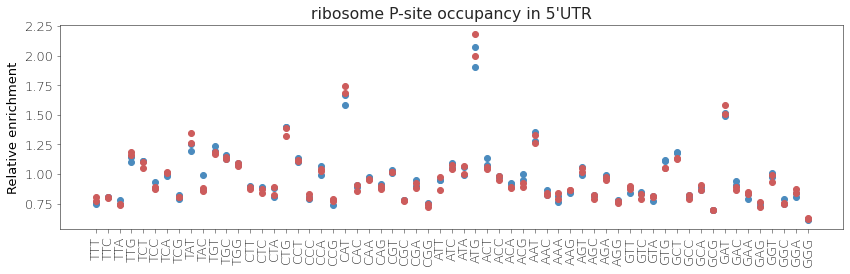

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

for cond in ['Rb_siControl_1', 'Rb_siControl_2']:

    ax.scatter(list(codon_usage_utr5_mean[cond].keys()), list(codon_usage_utr5_mean[cond].values()), c='#4B8BBE')
for cond in ['Rb_siTARG1_1', 'Rb_siTARG1_2']:
    ax.scatter(list(codon_usage_utr5_mean[cond].keys()), list(codon_usage_utr5_mean[cond].values()), c='indianred')

ax.set_ylabel('Relative enrichment')
# ax.set_ylim([1, 17])
ax.legend()
ax.set_title("ribosome P-site occupancy in 5'UTR")
plt.xticks(rotation=90)

plt.tight_layout()

No handles with labels found to put in legend.


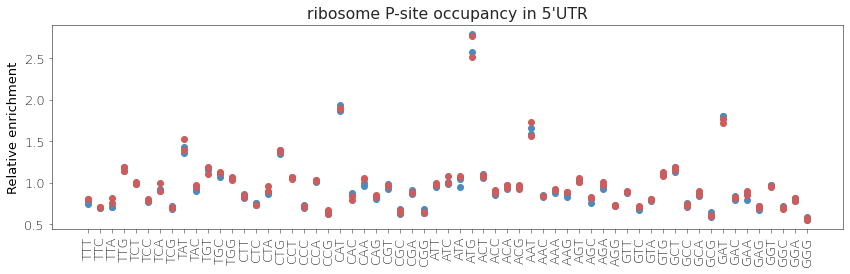

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))

for cond in ['Rb_RACK1_WT_1', 'Rb_RACK1_WT_2']:

    ax.scatter(list(codon_usage_utr5_mean[cond].keys()), list(codon_usage_utr5_mean[cond].values()), c='#4B8BBE')
for cond in ['Rb_RACK1_Mut_1', 'Rb_RACK1_Mut_2']:
    ax.scatter(list(codon_usage_utr5_mean[cond].keys()), list(codon_usage_utr5_mean[cond].values()), c='indianred')

ax.set_ylabel('Relative enrichment')
# ax.set_ylim([1, 17])
ax.legend()
ax.set_title("ribosome P-site occupancy in 5'UTR")
plt.xticks(rotation=90)

plt.tight_layout()

In [40]:
from scipy import stats


for codon in codon_table:
    WT_list = []
    KO_list = []
    for cond in ['Rb_RACK1_WT_1', 'Rb_RACK1_WT_2']:
        WT_list.append(codon_usage_utr5_mean[cond][codon])
    for cond in ['Rb_RACK1_Mut_1', 'Rb_RACK1_Mut_2']:
        KO_list.append(codon_usage_utr5_mean[cond][codon])

    print(codon + '\t' + str(stats.ttest_ind(WT_list, KO_list, equal_var=True)[1]))

# print(stats.mannwhitneyu(WT_list, KO_list))

TTT	0.17530183166543847
TTC	0.03486029688187352
TTA	0.11860607892266513
TTG	0.9273020739251547
TCT	0.5782503472096916
TCC	0.35364661066667125
TCA	0.5211278253733853
TCG	0.9423768642369363
TAT	0.4998913945982053
TAC	0.05986227585099984
TGT	0.6539317898677967
TGC	0.20829985376787985
TGG	0.9095685878836168
CTT	0.8968988428267126
CTC	0.012057860584198124
CTA	0.2149462524052607
CTG	0.7304646467484
CCT	0.7908549456932688
CCC	0.952568844035604
CCA	0.6470751955200325
CCG	0.9411001790704316
CAT	0.953321140410358
CAC	0.23084901757734125
CAA	0.047233652341207695
CAG	0.39387491419446174
CGT	0.7169048933723713
CGC	0.9767620451078362
CGA	0.7521262916259426
CGG	0.6083280520156208
ATT	0.1493905613674778
ATC	0.5094355755586705
ATA	0.21433467045409804
ATG	0.8427996224321336
ACT	0.917393114108716
ACC	0.6009303269331346
ACA	0.8163507385968078
ACG	0.9825073382289569
AAT	0.8023334731490337
AAC	0.7679230243426994
AAA	0.22561793965518095
AAG	0.14492325592467242
AGT	0.6977561131430331
AGC	0.25004161383514545
A

In [41]:
def get_codon_usage_cds(cond):
    codon_usage = dict()
    codon_usage["A"] = dict()
    codon_usage["P"] = dict()
    codon_usage["E"] = dict()
    
    for i, row in seq_pandas.dropna().iterrows():
        if len(row["cds"]) >= 21:
            total_reads = read_pandas[cond].loc[i, "cds"]
            total_reads_mean = np.mean(total_reads) * 3
            if float(sum(total_reads))/(len(total_reads)/3) >= 0.1:
                
    #         print([m.start() for m in re.finditer('CTG', row["utr5"])])
                for k in range(9, len(row["cds"]) - 11, 3):
                    P_site = str(row["cds"])[k:k+3]
                    A_site = str(row["cds"])[k+3:k+6]
                    E_site = str(row["cds"])[k-3:k]
                    
                    usage = float(sum(read_pandas[cond].loc[i, "cds"][k:k+3])) / total_reads_mean
                    if P_site in codon_usage["P"]:
                        codon_usage["P"][P_site].append(usage)
                    else:
                        codon_usage["P"][P_site] = [usage]
                        
                    if A_site in codon_usage["A"]:
                        codon_usage["A"][A_site].append(usage)
                    else:
                        codon_usage["A"][A_site] = [usage]

                    if E_site in codon_usage["E"]:
                        codon_usage["E"][E_site].append(usage)
                    else:
                        codon_usage["E"][E_site] = [usage]
    return codon_usage


In [42]:
pool = multiprocessing.Pool()

# pool object with number of element
pool = multiprocessing.Pool(processes=8)

# input list
inputs = alignments.keys()

# map the function to the list and pass
# function and input list as arguments
outputs = pool.map(get_codon_usage_cds, inputs)

In [43]:
codon_usage_cds = dict()
for i, cond in enumerate(inputs):
    codon_usage_cds[cond] = outputs[i]



In [44]:
from scipy.stats import sem

In [45]:
site = "A"

codon_usage_cds_mean = dict()
for cond in alignments.keys():
    codon_usage_cds_mean[cond] = dict()
    for codon in codon_usage_cds[cond][site]:
        codon_usage_cds_mean[cond][codon] = np.mean(codon_usage_cds[cond][site][codon])


In [46]:
for cond in alignments.keys():

    codon_usage_cds_mean[cond] = {codon: codon_usage_cds_mean[cond][codon] for codon in codon_table}


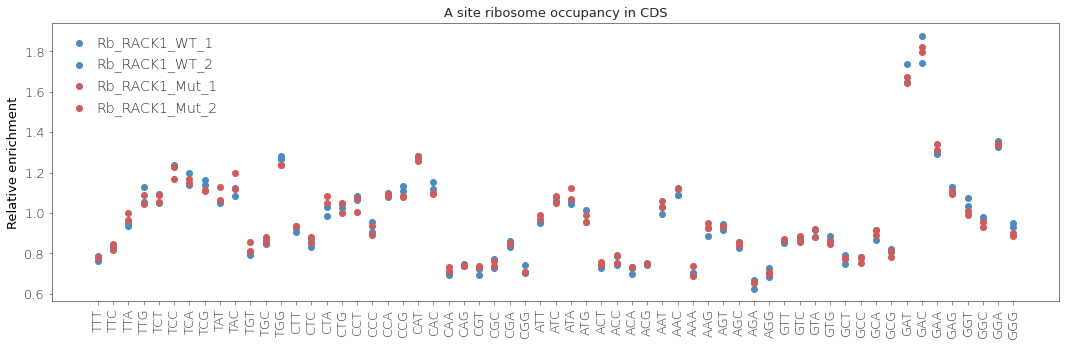

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

for cond in ['Rb_RACK1_WT_1', 'Rb_RACK1_WT_2']:

    ax.scatter(list(codon_usage_cds_mean[cond].keys()), list(codon_usage_cds_mean[cond].values()), c='#4B8BBE', label=cond)
for cond in ['Rb_RACK1_Mut_1', 'Rb_RACK1_Mut_2']:
    ax.scatter(list(codon_usage_cds_mean[cond].keys()), list(codon_usage_cds_mean[cond].values()), c='indianred', label=cond)

ax.set_ylabel('Relative enrichment')
# ax.set_ylim([1, 17])
ax.legend()
ax.set_title("A site ribosome occupancy in CDS", fontsize=13)
plt.xticks(rotation=90)

plt.tight_layout()

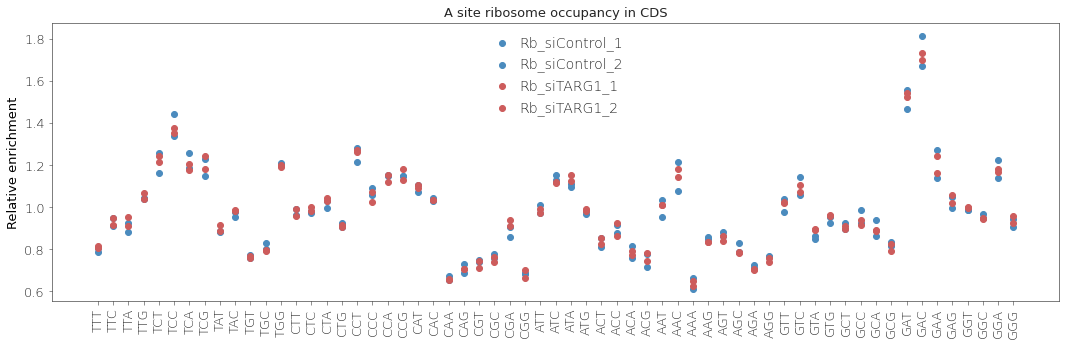

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))

for cond in ['Rb_siControl_1', 'Rb_siControl_2']:

    ax.scatter(list(codon_usage_cds_mean[cond].keys()), list(codon_usage_cds_mean[cond].values()), c='#4B8BBE', label=cond)
for cond in ['Rb_siTARG1_1', 'Rb_siTARG1_2']:
    ax.scatter(list(codon_usage_cds_mean[cond].keys()), list(codon_usage_cds_mean[cond].values()), c='indianred', label=cond)

ax.set_ylabel('Relative enrichment')
# ax.set_ylim([1, 17])
ax.legend()
ax.set_title("A site ribosome occupancy in CDS", fontsize=13)
plt.xticks(rotation=90)

plt.tight_layout()

In [49]:
from scipy import stats


for codon in codon_table:
    WT_list = []
    KO_list = []
    for cond in ['Rb_RACK1_WT_1', 'Rb_RACK1_WT_2']:
        WT_list.append(codon_usage_cds_mean[cond][codon])
    for cond in ['Rb_RACK1_Mut_1', 'Rb_RACK1_Mut_2']:
        KO_list.append(codon_usage_cds_mean[cond][codon])

    print(codon + '\t' + str(stats.ttest_ind(WT_list, KO_list, equal_var=True)[1]))

# print(stats.mannwhitneyu(WT_list, KO_list))

TTT	0.710799874862386
TTC	0.9821357123548922
TTA	0.17045751526752406
TTG	0.6383171556318009
TCT	0.9947264187808693
TCC	0.3478240423386687
TCA	0.8397012150123402
TCG	0.09420690152257945
TAT	0.28845670049423033
TAC	0.377037812764059
TGT	0.27292088480148186
TGC	0.5887973696590645
TGG	0.041288514722237
CTT	0.24136432762942098
CTC	0.5525835364944653
CTA	0.16616663211247212
CTG	0.7007273731465102
CCT	0.42001589647823356
CCC	0.6520009742878126
CCA	0.8997345304009958
CCG	0.09987657465912687
CAT	0.7841236413987707
CAC	0.14494591249803063
CAA	0.15934539824337082
CAG	0.8115830018688925
CGT	0.23298917516421166
CGC	0.9918767714822949
CGA	0.89761436120351
CGG	0.5949698833509666
ATT	0.1157106076486736
ATC	0.9401327476453923
ATA	0.27203403358868167
ATG	0.7721174331418911
ACT	0.3647782761541789
ACC	0.8596866115282419
ACA	0.27045695295274574
ACG	0.8634422651155422
AAT	0.2757981097837196
AAC	0.0066631212097871
AAA	0.7963581901697581
AAG	0.30373611706602577
AGT	0.9742132019874934
AGC	0.648720478639162
AGA